# Ex 3. Separate inhibitory population

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

**3.1.** Write down the total input to an excitatory and an inhibitory neuron. Show that the average input
to an excitatory neuron is equivalent to the input to a neuron in the model of exercise 2, for b = 0.

**Part 1.**
The total input to an excitatory neuron is comprised of inputs from inhibitory and excitatory neurons:
$$h_{i} = h_{exc} - h_{inh}$$
Firstly, we consider $h_{exc}$:
\begin{align}
h_{exc} = W \sigma_{exc}
 = \sum_{j}^{N} W_{ij}^{E \leftarrow E} \sigma_{j}(t)
 = \sum_{j}^{N} \frac{c}{N} \sum_{\mu}^{M} \xi_{i}^{\mu} \xi_{j}^{\mu} \sigma_{j}(t)
\end{align}
Secondly, we consider $h_{inh}$:
\begin{align}
h_{inh} = W \sigma_{inh}
 = \sum_{k}^{K} W_{ik}^{E \leftarrow I} \sigma_{k}^{I}(t)
 = \sum_{k}^{K} \frac{ca}{N_{I}} \sum_{\mu}^{M} \xi_{i}^{\mu} \sigma_{k}^{I}(t)
\end{align}
Hence, the total input to the excitatory neuron is:
\begin{align}
h_{i} = \sum_{j}^{N} W_{ij}^{E \leftarrow E} \sigma_{j}(t) - \sum_{k}^{N_{I}} W_{ik}^{E \leftarrow I} \sigma_{k}^{I}(t)
\end{align}

Analogously, the total input to the inhibitory neuron is equal to:
\begin{align}
h_{k} = \sum_{k} W_{ki}^{I \leftarrow E} \sigma_{k}(t) = \frac{1}{K} \sum_{k} \sigma_{k}(t),
\end{align}
where $k \in S$, where $S$ is the set of pre-synaptic neurons.


**Part 2.**
1. Inhibiting neurons have linear gain function and fire stochastically: $Prob(\sigma_k = +1| h_{k}^{inh}) = h_{k}^{inh}$, where k is an index of an inhibitory neuron $1 \le k \le N_{I}$.

2. Each inhibitory neuron $k$ recieves receives input from $K$ excitatory neurons. Connections are random and of equal weight $w_{ki}^{I \leftarrow E} = \frac{1}{K}$.
3. Thus, the input potential of the neuron k is $h_{k}^{inh} = \frac{1}{K} \sum_{j \in S}$, where S is the set of pre-synaptic neurons.
4. Connection from inhibitory neuron back to excitatory neuron $w_{ik}^{E \leftarrow I} = \frac{a}{N_I} \sum_{\mu} \xi_{i}^{\mu}$
5. The total input from inhibitory neuron to excitatory is, therefore, $h_{inh} = \sum_{k} w_{ik}^{E \leftarrow I} \sigma_{k} = \sum_{k} \frac{a}{N_I} \sum_{\mu} \xi_{i}^{\mu} \sigma_{k} = \frac{ca}{N_I} \sum_{k} \sum_{\mu} \xi_{i}^{\mu} \sigma_{k}$.
6. Putting everything together and considering that $k=j$ and $N=N_I$.
$$<h_{i}(t)> = \frac{c}{N} \sum_{\mu}^{M} \xi_{i}^{\mu} \sum_{j}^{N} \xi_{j}^{\mu} \sigma_{j}(t) - \frac{ca}{N} \sum_{j}^{N} \sum_{\mu}^{M} \xi_{i}^{\mu} $$
$$ = \frac{c}{N} \sum_{\mu}^{M} \sum_{j}^{N} \xi_{i}^{\mu} (\xi_{j}^{\mu} - a) \sigma_{j}(t)$$
Which is equivalent to the low-activity Hopfield model discussed in part 2:
$$<h_{i}(t)> = \sum_{j}^{N} w_{ij} \sigma_{j}(t)$$
$$ = \frac{c}{N} \sum_{j}^{N} \sum_{\mu}^{M} (\xi_{i}^{\mu}-b)(\xi_{j}^{\mu}-a) \sigma_{j}(t)$$
$$ = \frac{c}{N} \sum_{j}^{N} \sum_{\mu}^{M} \xi_{i}^{\mu}(\xi_{j}^{\mu}-a) \sigma_{j}(t), QED$$

In [5]:
def generate_patterns(M, N, a):
    """
    Args:
        M: number of patterns
        N: number of neurons
    Output:
        Generates binary balanced random patterns.
    """
    patterns = np.random.choice([0, 1], size=(M, N), p=[1-a,a])
    return patterns

def generate_patterns_with_fixed_active_neurons(num_patterns, num_neurons, active_fraction=0.1):
    # Calculate the number of active neurons per pattern
    num_active_neurons = int(np.floor(active_fraction * num_neurons))
    
    # Initialize the pattern array with all zeros
    patterns = np.zeros((num_patterns, num_neurons), dtype=int)
    
    for i in range(num_patterns):
        active_indices = np.random.choice(num_neurons, num_active_neurons, replace=False)
        patterns[i, active_indices] = 1
    
    return patterns

class ExcitatoryInhibitory:
    def __init__(self, theta, num_steps):
        self.theta = theta
        self.k = num_steps
    
    def compute_EE_overlap(self, patterns, sigma, N, a):
        M = patterns.shape[0]
        distances = np.zeros(M)
        m_EE = np.zeros(M)
        c = 2/(a*(1-a))
        for mu in range(M):
            m_EE[mu] = c/N * np.dot(patterns[mu], sigma)
            distances[mu] = np.sum(patterns[mu] == sigma)
        return m_EE, distances
    
    def compute_hi_exc(self, patterns, m_EE):
        return np.dot(m_EE, patterns)
    
    def compute_hk(self, sigma, N, K, N_I):
        hk = np.zeros(N_I)
        for i in range(N_I):
            chosen_neurons = np.random.choice(N, K)
            #print(np.sum(sigma[chosen_neurons]))
            hk[i] = 1/K * np.sum(sigma[chosen_neurons])
        return hk
    
    def compute_IE_overlap(self, N_I, sigma_I):
        mean_activity_inhibitory = np.mean(sigma_I)
        return mean_activity_inhibitory
    
    def compute_hi_inh(self, patterns, mean_activity_inhibitory, a, N):
        c = 2/(a*(1-a))
        hi_inh = np.zeros(N)
        for i in range(N):
            #print(patterns[:,i]*mean_activity_inhibitory)
            hi_inh[i] = c*a*np.sum(patterns[:,i]*mean_activity_inhibitory)
        return hi_inh
    
    def compute_state_exc(self, hi):
        return np.tanh(hi - self.theta)
    
    def stoch_var_exc(self, state):
        firing_probability = 0.5 * (state + 1) 
        sigma = np.random.binomial(1, firing_probability) # P{σ_i(t) = +1 | S_i(t)}
        return sigma
    
    def stoch_var_inh(self, hk):
        sigma_I = np.random.binomial(1, hk) # P{σ_i(t) = +1 | S_i(t)}
        return sigma_I
    
    def hamming_distance(self, state, patterns, N):
        ham_dist = np.zeros(patterns.shape[0])
        for mu in range(patterns.shape[0]):
            ham_dist[mu] = (N - np.sum(patterns[mu]==state))/(2*N)
        return ham_dist
    
    def synchronous_simulation(self, sigma_E, sigma_I, patterns, N, N_I, K, a):
        store = {'overlaps': [],
                 'hamming_distances':[],
                 'excitatory_states':[],
                 'inhibitory_states':[],
                 'overs':[]}
        #store['inhibitory_states'].append(sigma_I)
        store['excitatory_states'].append(sigma_E)
        store['hamming_distances'].append(self.hamming_distance(sigma_E, patterns, N))
        hello = 0
        for i in range(self.k):
            m_EE, dist = self.compute_EE_overlap(patterns, sigma_E, N, a)
            hi_exc = self.compute_hi_exc(patterns, m_EE)
        
            mean_activity_inhibitory = self.compute_IE_overlap(N_I, sigma_I)
            hi_inh = self.compute_hi_inh(patterns, mean_activity_inhibitory, a, N)
            hi = hi_exc - hi_inh

            hk = self.compute_hk(sigma_E, N, K, N_I)
            sigma_I = self.stoch_var_inh(hk)

            state_E = self.compute_state_exc(hi)
            sigma_E = self.stoch_var_exc(state_E)

            store['overlaps'].append(m_EE)
            store['overs'].append(np.dot(2*patterns-1, 2*state_E-1))
            store['hamming_distances'].append(self.hamming_distance(sigma_E, patterns, N))
            #store['hamming_distances'].append((N-dist)/(2*N))
            store['excitatory_states'].append(sigma_E)
            store['inhibitory_states'].append(sigma_I)
            hello += 1

        return store
    
    def asynchronous_simulation(self, sigma_E, sigma_I, patterns, N, N_I, K, a):
        store = {'overlaps': [],
                 'hamming_distances':[],
                 'excitatory_states':[],
                 'inhibitory_states':[],
                 'overs':[]}
        store['inhibitory_states'].append(sigma_I)
        store['excitatory_states'].append(sigma_E)
        store['hamming_distances'].append(self.hamming_distance(sigma_E, patterns, N))
        store['overs'].append(np.dot(2*patterns-1, 2*sigma_E-1))
        for i in range(self.k):
            hk = self.compute_hk(sigma_E, N, K, N_I)
            sigma_I = self.stoch_var_inh(hk)

            m_EE, dist = self.compute_EE_overlap(patterns, sigma_E, N, a)
            hi_exc = self.compute_hi_exc(patterns, m_EE)

            mean_activity_inhibitory = self.compute_IE_overlap(N_I, sigma_I)
            hi_inh = self.compute_hi_inh(patterns, mean_activity_inhibitory, a, N)
            hi = hi_exc - hi_inh

            state_E = self.compute_state_exc(hi)
            sigma_E = self.stoch_var_exc(state_E)

            store['overlaps'].append(m_EE)
            store['overs'].append(np.dot(patterns, state_E))
            store['hamming_distances'].append(self.hamming_distance(sigma_E, patterns, N))
            #store['hamming_distances'].append((N-dist)/(2*N))
            store['excitatory_states'].append(sigma_E)
            store['inhibitory_states'].append(sigma_I)

        return store
    

In [7]:
# Parameters
N = 300  # Number of excitatory neurons
N_I = 80 # Number of inhibitory neurons
M = 3   # Number of patterns
K = 60   # Connections from excitatory to inhibitory
a = 0.1  # Activity level
theta = 1 # Threshold
beta = 4
num_steps = 100

#patterns = generate_patterns(M, N, a)
patterns = generate_patterns_with_fixed_active_neurons(M, N, active_fraction=a)

# Initial random states
#state_E = np.random.choice([0, 1], size=N, p=[1-a, a])
#state_I = np.random.choice([0, 1], size=N_I, p=[1-a, a])
state_E = np.random.choice([0, 1], size=N, p=[1-a, a])
state_E = generate_patterns_with_fixed_active_neurons(1, N, active_fraction=a).squeeze(0)
choose_neurons = np.random.choice(N, size=K)

#state_I = np.random.choice([0,1], size=N_I, p=[1-a, np.mean(state_E[choose_neurons])])
state_I = np.zeros(N_I)

model = ExcitatoryInhibitory(theta, num_steps)
store = model.synchronous_simulation(state_E, state_I, patterns, N, N_I, K, a)


In [8]:
something=np.sum(np.array(store['excitatory_states']), axis=1)
print("Average number of active neurons per excitatory state:", np.round(something.mean(),3))

Average number of active neurons per excitatory state: 36.228


In [9]:
overlaps = np.array(store['overlaps'])
print("Shape of overlaps:", overlaps.shape)

hamming_distances = np.array(store["hamming_distances"])
print("Shape of hamming distances:", hamming_distances.shape)

excitatory_states = np.array(store["excitatory_states"])
print("Shape of the excitatory states array:", excitatory_states.shape)

inhibitory_states = np.array(store["inhibitory_states"])
print("Shape of inhibitory states array:", inhibitory_states.shape)

#overs = np.array(store['overs'])
#print(overs.shape)


Shape of overlaps: (100, 3)
Shape of hamming distances: (101, 3)
Shape of the excitatory states array: (101, 300)
Shape of inhibitory states array: (100, 80)


**3.3.** Studying the storage capacity

In [10]:
def retrieve_patterns(hamming_distances, N):
    final_states = hamming_distances[-1, :]
    error = np.mean(final_states)
    retrieval_threshold = 0.05
    retrieved_count = np.sum(final_states <= retrieval_threshold)
    return error, retrieved_count/N

retrieve_patterns(hamming_distances, 300)

(0.09500000000000001, 0.0)

In [12]:
M = np.linspace(5,100,10)
N = 300
retrieved_patterns_sync = np.zeros(len(M))
retrieve_patterns_async = np.zeros(len(M))
a = 0.1
sim_steps = 10
initial_state_E = np.random.choice([0, 1], size=N, p=[1-a, a])
initial_state_I = np.random.choice([0, 1], size=N, p=[1-a, a])

for i,m in enumerate(tqdm.tqdm(M)):
    p1 = 0
    p2 = 0
    for sim in range(sim_steps):
        patterns = generate_patterns(int(m), N, a)
        for mu in range(int(m)):
            initial_state_E = patterns[mu].copy()
            initial_state_E[np.random.choice(N, int(0.05*N), replace=False)] = 1 - initial_state_E[np.random.choice(N, int(0.05*N), replace=False)]
            initial_state_I = np.zeros(N_I)
            
            store_sync = model.synchronous_simulation(initial_state_E, initial_state_I, patterns, N, N_I, K, a)
            store_async = model.asynchronous_simulation(initial_state_E, initial_state_I, patterns, N, N_I, K, a)
            hd_sync = np.stack(store_sync['hamming_distances'])
            __, r_p1 = retrieve_patterns(hd_sync, N)
            p1 += r_p1/int(m)
            hd_async = np.stack(store_async['hamming_distances'])
            __, r_p2 = retrieve_patterns(hd_async, N)
            p2 += r_p2/int(m)
    print(p1/sim_steps, p2/sim_steps)
    retrieved_patterns_sync[i] = p1/sim_steps
    retrieve_patterns_async[i] = p2/sim_steps

 10%|█         | 1/10 [00:15<02:22, 15.84s/it]

0.0002666666666666667 0.0002666666666666667


 20%|██        | 2/10 [01:05<04:47, 35.91s/it]

4.4444444444444447e-05 4.4444444444444447e-05


 30%|███       | 3/10 [02:33<06:57, 59.68s/it]

0.0031794871794871794 2.564102564102564e-05


 40%|████      | 4/10 [04:56<09:14, 92.33s/it]

0.022675925925925912 3.703703703703704e-05


 50%|█████     | 5/10 [08:04<10:35, 127.08s/it]

0.0014468085106382977 1.4184397163120568e-05


 60%|██████    | 6/10 [12:11<11:11, 167.76s/it]

0.010602339181286561 5.263157894736842e-05


 70%|███████   | 7/10 [16:54<10:16, 205.55s/it]

0.05642156862745101 4.901960784313726e-06


 80%|████████  | 8/10 [22:31<08:14, 247.35s/it]

0.04132478632478644 0.00022222222222222223


 90%|█████████ | 9/10 [28:59<04:51, 291.15s/it]

0.03407490636704121 0.0001947565543071161


100%|██████████| 10/10 [36:21<00:00, 218.16s/it]

0.043920000000000084 0.0004300000000000001


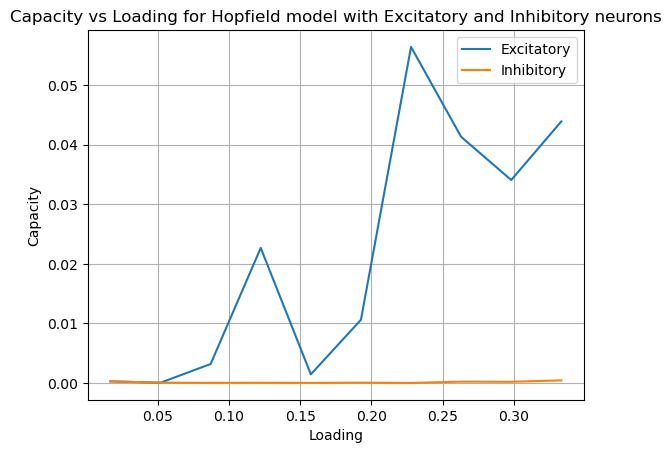

In [39]:
#np.save("retrieved_patterns_sync.npy", retrieved_patterns_sync)
#np.save("retrieve_patterns_async.npy", retrieve_patterns_async)

retrieve_patterns_sync = np.load("retrieved_patterns_sync.npy")
retrieve_patterns_async = np.load("retrieve_patterns_async.npy")

plt.figure()
plt.plot(M/N, retrieve_patterns_sync, label='Excitatory')
plt.plot(M/N, retrieve_patterns_async, label='Inhibitory')
plt.xlabel('Loading')
plt.ylabel('Capacity')
plt.title('Capacity vs Loading for Hopfield model with Excitatory and Inhibitory neurons')
plt.legend()
plt.grid()

**3.4.** Repeat question 3.3 with this model. Does the second inhibitory population improve the capacity?

In [18]:
class ExcitatoryInhibitoryWithSecondInhibitory(ExcitatoryInhibitory):
    def compute_EE_overlap(self, patterns, sigma, N, a):
        M = patterns.shape[0]
        distances = np.zeros(M)
        m_EE = np.zeros(M)
        c = 2 / (a * (1 - a))
        for mu in range(M):
            m_EE[mu] = c / N * np.dot(patterns[mu], sigma)
            distances[mu] = np.sum(patterns[mu] == sigma)
        return m_EE, distances

    def compute_hk_second_inh(self, sigma, N, K, N_I):
        hk = np.zeros(N_I)
        for i in range(N_I):
            chosen_neurons = np.random.choice(N, K, replace=False)
            hk[i] = 1 / K * np.sum(sigma[chosen_neurons])
        return hk
    
    def compute_inputs_inh2(self, sigma_E, N_I, sigma_I2, a):
        c = 2/(a*(1-a))
        mean_activity = np.mean(sigma_E)
        if mean_activity > a:
            return np.sum(sigma_I2) * c * a / N_I
        else:
            return np.sum(np.zeros(N_I))

    def synchronous_simulation_with_second_inh(self, sigma_E, sigma_I1, sigma_I2, patterns, N, N_I, K, a):
        store = {'overlaps': [], 'hamming_distances': [], 'excitatory_states': [], 'inhibitory_states1': [], 'inhibitory_states2': []}
        store['excitatory_states'].append(sigma_E)
        store['hamming_distances'].append(self.hamming_distance(sigma_E, patterns, N))
        for i in range(self.k):
            m_EE, dist = self.compute_EE_overlap(patterns, sigma_E, N, a)
            hi_exc = self.compute_hi_exc(patterns, m_EE)
            mean_activity_inhibitory = self.compute_IE_overlap(N_I, sigma_I1)

            hi_inh1 = self.compute_hi_inh(patterns, mean_activity_inhibitory, a, N)
            hi_inh2 = self.compute_inputs_inh2(sigma_E, N_I, sigma_I2, a)
            
            hi = hi_exc - hi_inh1 - hi_inh2
            hk1 = self.compute_hk(sigma_E, N, K, N_I)
            hk2 = self.compute_hk_second_inh(sigma_E, N, K, N_I)
            sigma_I1 = self.stoch_var_inh(hk1)
            sigma_I2 = self.stoch_var_inh(hk2)
            state_E = self.compute_state_exc(hi)
            sigma_E = self.stoch_var_exc(state_E)
            store['overlaps'].append(m_EE)
            store['hamming_distances'].append(self.hamming_distance(sigma_E, patterns, N))
            store['excitatory_states'].append(sigma_E)
            store['inhibitory_states1'].append(sigma_I1)
            store['inhibitory_states2'].append(sigma_I2)
        return store
    
    def asynchronous_simulation_with_second_inh(self, sigma_E, sigma_I1, sigma_I2, patterns, N, N_I, K, a):
        store = {'overlaps': [], 'hamming_distances': [], 'excitatory_states': [], 'inhibitory_states1': [], 'inhibitory_states2': []}
        store['excitatory_states'].append(sigma_E)
        store['hamming_distances'].append(self.hamming_distance(sigma_E, patterns, N))
        for i in range(self.k):
            hk1 = self.compute_hk(sigma_E, N, K, N_I)
            hk2 = self.compute_hk_second_inh(sigma_E, N, K, N_I)

            mean_activity_inhibitory = self.compute_IE_overlap(N_I, sigma_I1)
            hi_inh1 = self.compute_hi_inh(patterns, mean_activity_inhibitory, a, N)
            hi_inh2 = self.compute_inputs_inh2(sigma_E, N_I, sigma_I2, a)

            sigma_I1 = self.stoch_var_inh(hk1)
            sigma_I2 = self.stoch_var_inh(hk2)
            m_EE, dist = self.compute_EE_overlap(patterns, sigma_E, N, a)
            hi_exc = self.compute_hi_exc(patterns, m_EE)

            hi_inh2 = self.compute_inputs_inh2(sigma_E, N_I, sigma_I2, a)
            hi = hi_exc - hi_inh1 - hi_inh2

            sigma_I1 = self.stoch_var_inh(hk1)
            sigma_I2 = self.stoch_var_inh(hk2)
            state_E = self.compute_state_exc(hi)
            sigma_E = self.stoch_var_exc(state_E)
            store['overlaps'].append(m_EE)
            store['hamming_distances'].append(self.hamming_distance(sigma_E, patterns, N))
            store['excitatory_states'].append(sigma_E)
            store['inhibitory_states1'].append(sigma_I1)
            store['inhibitory_states2'].append(sigma_I2)
        return store

# Parameters for the new simulation
model_with_second_inh = ExcitatoryInhibitoryWithSecondInhibitory(theta, num_steps)

# Generating patterns
patterns = generate_patterns_with_fixed_active_neurons(5, N, active_fraction=a)

# Initial random states
initial_state_E = patterns[0].copy()
flip_indices = np.random.choice(N, size=int(0.05 * N), replace=False)
initial_state_E[flip_indices] = 1 - initial_state_E[flip_indices]
initial_state_I1 = np.random.choice([0, 1], size=N_I, p=[1 - a, a])
initial_state_I2 = np.zeros(N_I)

# Running the simulation
store = model_with_second_inh.synchronous_simulation_with_second_inh(initial_state_E, initial_state_I1, initial_state_I2, patterns, N, N_I, K, a)
print("done")

done


100%|██████████| 10/10 [23:51<00:00, 143.12s/it]


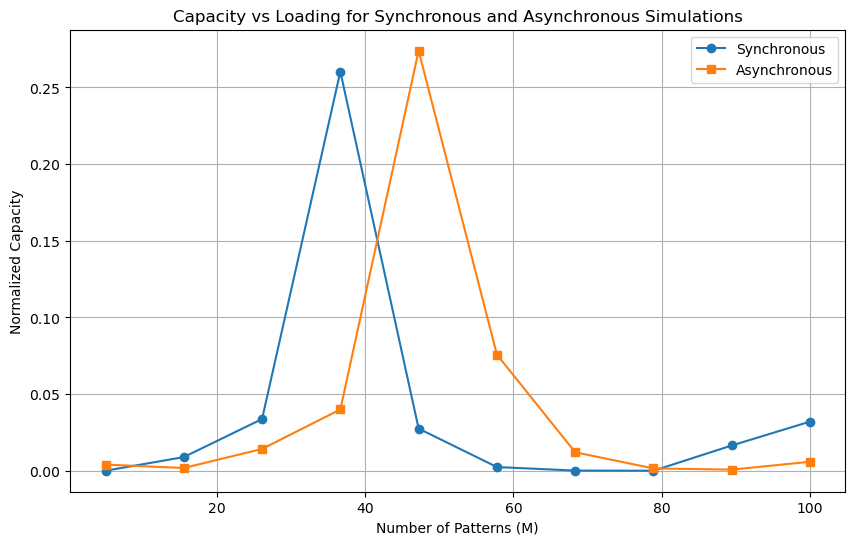

In [24]:
# Set up simulation parameters
M = np.linspace(5, 100, 10)  # Adjusted number of patterns range to match the second snippet
N = 300  # Total number of neurons
N_I = 80  # Number of inhibitory neurons
K = 50  # Connectivity parameter
a = 0.1  # Activity level
sim_steps = 10  # Number of simulation steps per loading scenario

# Initialize storage for results
retrieved_patterns_sync = np.zeros(len(M))
retrieved_patterns_async = np.zeros(len(M))

# Initialize the model with hypothetical parameters
model = ExcitatoryInhibitoryWithSecondInhibitory(theta=1, num_steps=50)

# Simulation loop for each pattern count
for i, m in enumerate(tqdm.tqdm(M)):
    p_sync = p_async = 0
    for sim in range(sim_steps):
        patterns = generate_patterns(int(m), N, a)  # Assuming generate_patterns correctly initializes the patterns
        for mu in range(int(m)):
            initial_state_E = patterns[mu].copy()  # Use each pattern as the initial state
            initial_state_I = np.zeros(N_I)  # Resetting initial inhibitory state for each pattern
            initial_state_I2 = np.zeros(N_I)  # Resetting second inhibitory state for each pattern

            # Introduce bit flipping for the initial state
            flip_indices = np.random.choice(N, int(0.05 * N), replace=False)
            initial_state_E[flip_indices] = 1 - initial_state_E[flip_indices]

            # Run synchronous simulation
            store_sync = model.synchronous_simulation_with_second_inh(initial_state_E, initial_state_I, initial_state_I2, patterns, N, N_I, K, a)
            hd_sync = np.array(store_sync['hamming_distances'])
            _, r_p_sync = retrieve_patterns(hd_sync, int(m))
            p_sync += r_p_sync

            # Run asynchronous simulation
            store_async = model.asynchronous_simulation_with_second_inh(initial_state_E, initial_state_I, initial_state_I2, patterns, N, N_I, K, a)
            hd_async = np.array(store_async['hamming_distances'])
            _, r_p_async = retrieve_patterns(hd_async, int(m))
            p_async += r_p_async

    # Calculate the average retrieval performance over all simulations
    retrieved_patterns_sync[i] = p_sync / (sim_steps * int(m))
    retrieved_patterns_async[i] = p_async / (sim_steps * int(m))

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(M, retrieved_patterns_sync, '-o', label='Synchronous')
plt.plot(M, retrieved_patterns_async, '-s', label='Asynchronous')
plt.xlabel('Number of Patterns (M)')
plt.ylabel('Normalized Capacity')
plt.title('Capacity vs Loading for Synchronous and Asynchronous Simulations')
plt.legend()
plt.grid(True)
plt.show()

**3.5.** With the same parameters as previously, M = 10 patterns, and input strength J = 2, present a sequence of the patterns in random order to the network.

Plot the overlaps over time, and show a raster plot of the spike variables σi(t) of a few excitatory and inhibitory neurons. Does the network correctly retrieve all the presented patterns? If not, what is the reason?
Hint: during the presentation of pattern ξμ, feed the excitatory neurons with the input of eq.(11) during 5 time steps, and let the network evolve for 50 time steps. Do this for a random sequence of the M patterns, of length ∼ 10.

Finished applying external input for pattern 1/10
Finished applying external input for pattern 2/10
Finished applying external input for pattern 3/10
Finished applying external input for pattern 4/10
Finished applying external input for pattern 5/10
Finished applying external input for pattern 6/10
Finished applying external input for pattern 7/10
Finished applying external input for pattern 8/10
Finished applying external input for pattern 9/10
Finished applying external input for pattern 10/10


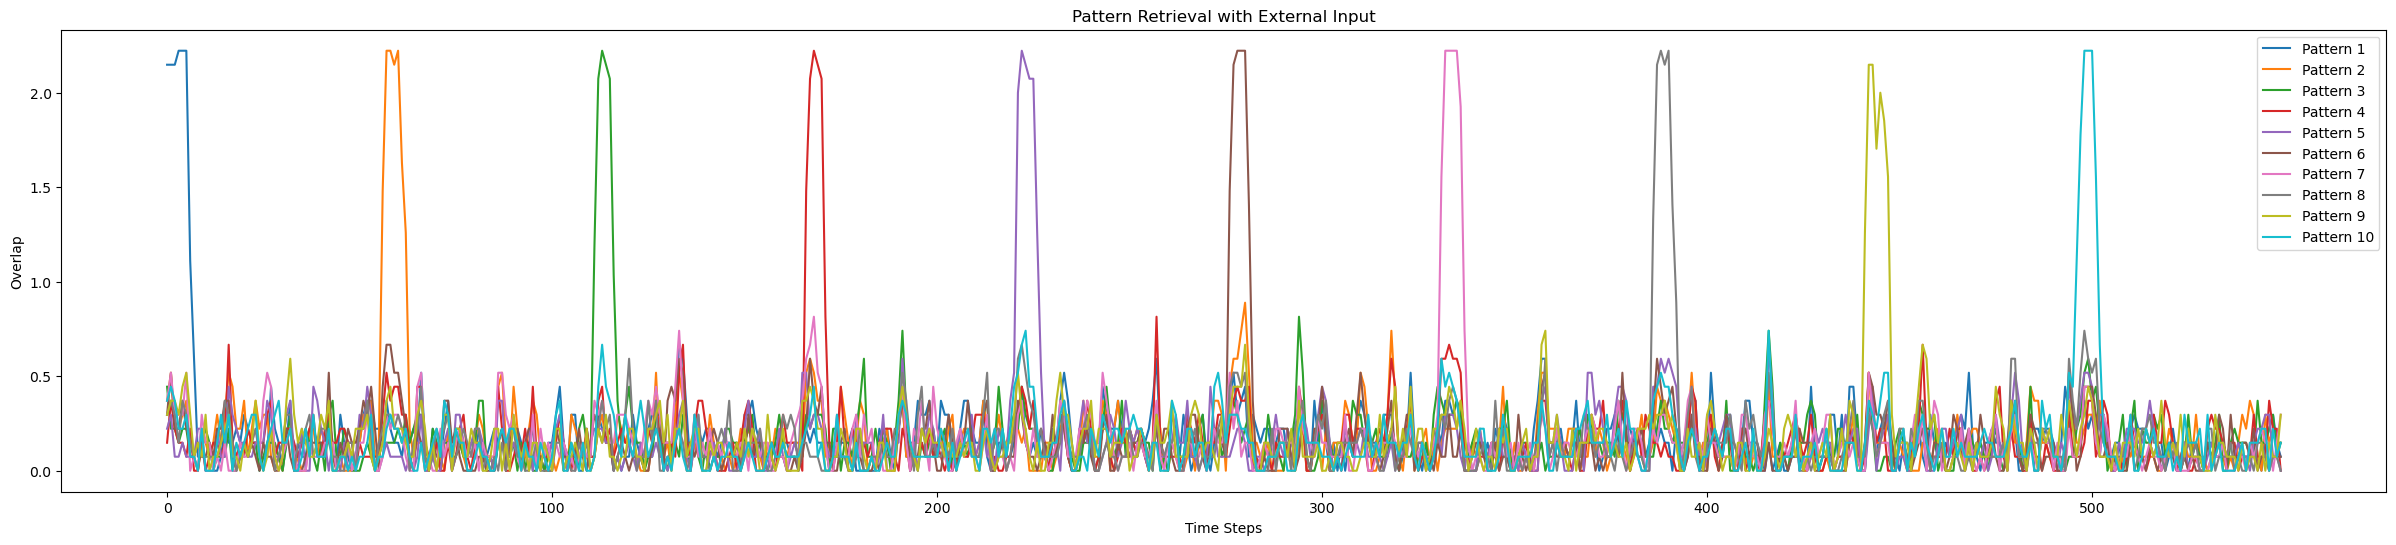

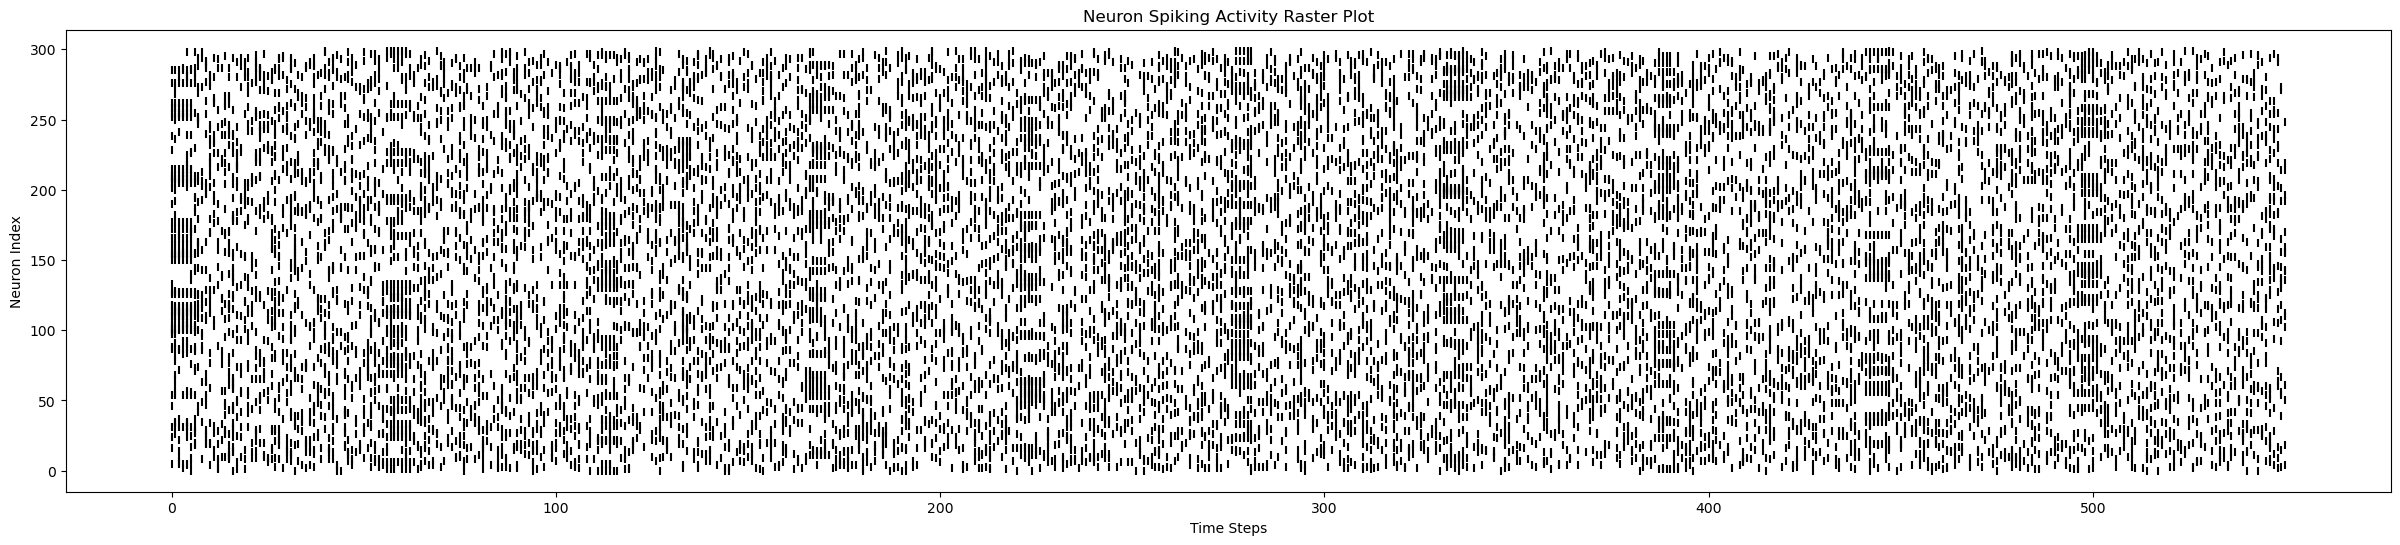

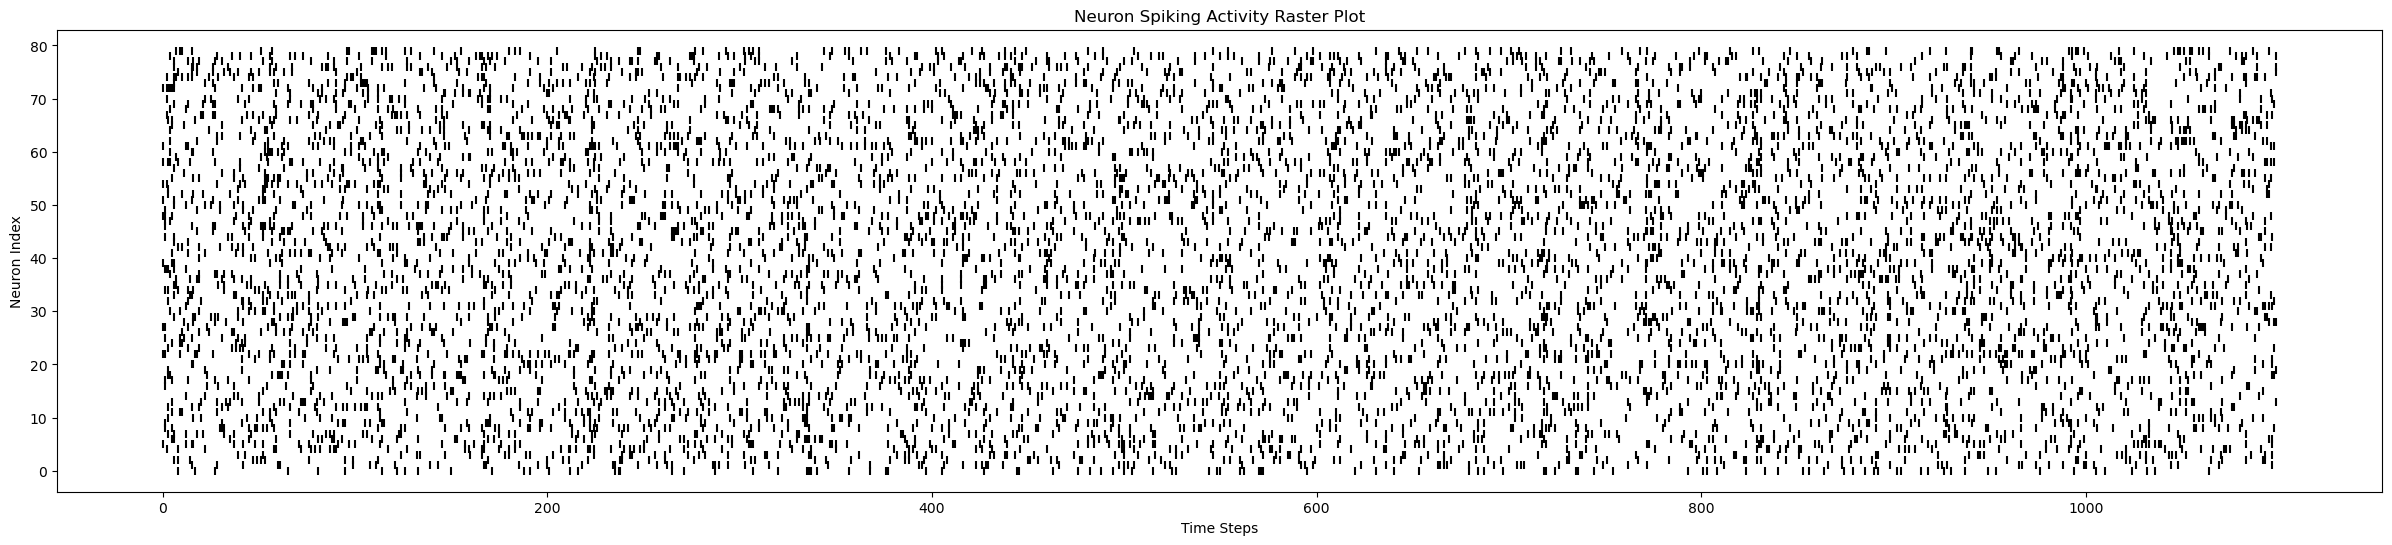

In [34]:
import numpy as np
import matplotlib.pyplot as plt

class ExcitatoryInhibitoryWithExternalInput(ExcitatoryInhibitoryWithSecondInhibitory):
    def add_external_input(self, pattern, J):
        return J * (pattern - np.mean(pattern))
    
    def synchronous_simulation_with_external_input(self, sigma_E, sigma_I1, sigma_I2, patterns, N, N_I, K, a, J, presentation_steps=5, evolve_steps=50):
        store = {'overlaps': [], 'hamming_distances': [], 'excitatory_states': [], 'inhibitory_states1': [], 'inhibitory_states2': [], 'external_input': [], 'neuron_activity': []}
        store['excitatory_states'].append(sigma_E.copy())
        store['hamming_distances'].append(self.hamming_distance(sigma_E, patterns, N))
        store['neuron_activity'].append(sigma_E.copy())

        for pattern_idx, pattern in enumerate(patterns):
            # Apply external input
            for step in range(presentation_steps):
                m_EE, dist = self.compute_EE_overlap(patterns, sigma_E, N, a)
                hi_exc = self.compute_hi_exc(patterns, m_EE)
                mean_activity_inhibitory1 = self.compute_IE_overlap(N_I, sigma_I1)
                mean_activity_inhibitory2 = self.compute_IE_overlap(N_I, sigma_I2)
                hi_inh1 = self.compute_hi_inh(patterns, mean_activity_inhibitory1, a, N)
                hi_inh2 = self.compute_hi_inh(patterns, mean_activity_inhibitory2, a, N)
                external_input = self.add_external_input(pattern, J)
                hi = hi_exc - hi_inh1 - hi_inh2 + external_input
                hk1 = self.compute_hk(sigma_E, N, K, N_I)
                hk2 = self.compute_hk_second_inh(sigma_E, N, K, N_I)
                sigma_I1 = self.stoch_var_inh(hk1)
                sigma_I2 = self.stoch_var_inh(hk2)
                state_E = self.compute_state_exc(hi)
                sigma_E = self.stoch_var_exc(state_E)
                store['overlaps'].append(m_EE)
                store['hamming_distances'].append(self.hamming_distance(sigma_E, patterns, N))
                store['excitatory_states'].append(sigma_E.copy())
                store['inhibitory_states1'].append(sigma_I1)
                store['inhibitory_states2'].append(sigma_I2)
                store['external_input'].append(external_input)
                store['neuron_activity'].append(sigma_E.copy())
            
            # Evolve without external input
            for step in range(evolve_steps):
                m_EE, dist = self.compute_EE_overlap(patterns, sigma_E, N, a)
                hi_exc = self.compute_hi_exc(patterns, m_EE)
                mean_activity_inhibitory1 = self.compute_IE_overlap(N_I, sigma_I1)
                mean_activity_inhibitory2 = self.compute_IE_overlap(N_I, sigma_I2)
                hi_inh1 = self.compute_hi_inh(patterns, mean_activity_inhibitory1, a, N)
                hi_inh2 = self.compute_hi_inh(patterns, mean_activity_inhibitory2, a, N)
                hi = hi_exc - hi_inh1 - hi_inh2
                hk1 = self.compute_hk(sigma_E, N, K, N_I)
                hk2 = self.compute_hk_second_inh(sigma_E, N, K, N_I)
                sigma_I1 = self.stoch_var_inh(hk1)
                sigma_I2 = self.stoch_var_inh(hk2)
                state_E = self.compute_state_exc(hi)
                sigma_E = self.stoch_var_exc(state_E)
                store['overlaps'].append(m_EE)
                store['hamming_distances'].append(self.hamming_distance(sigma_E, patterns, N))
                store['excitatory_states'].append(sigma_E.copy())
                store['inhibitory_states1'].append(sigma_I1)
                store['inhibitory_states2'].append(sigma_I2)
                store['neuron_activity'].append(sigma_E.copy())

            print(f"Finished applying external input for pattern {pattern_idx+1}/{len(patterns)}")
                
        return store
    
    def asynchronous_simulation_with_external_input(self, sigma_E, sigma_I1, sigma_I2, patterns, N, N_I, K, a, J, presentation_steps=5, evolve_steps=50):
        store = {'overlaps': [], 'hamming_distances': [], 'excitatory_states': [], 'inhibitory_states1': [], 'inhibitory_states2': [], 'external_input': [], 'neuron_activity': []}
        store['excitatory_states'].append(sigma_E.copy())
        store['hamming_distances'].append(self.hamming_distance(sigma_E, patterns, N))
        store['neuron_activity'].append(sigma_E.copy())

        for pattern_idx, pattern in enumerate(patterns):
            # Apply external input
            for step in range(presentation_steps):
                hk1 = self.compute_hk(sigma_E, N, K, N_I)
                hk2 = self.compute_hk_second_inh(sigma_E, N, K, N_I)
                sigma_I1 = self.stoch_var_inh(hk1)
                sigma_I2 = self.stoch_var_inh(hk2)

                mean_activity_inhibitory1 = self.compute_IE_overlap(N_I, sigma_I1)
                mean_activity_inhibitory2 = self.compute_IE_overlap(N_I, sigma_I2)
                hi_inh1 = self.compute_hi_inh(patterns, mean_activity_inhibitory1, a, N)
                hi_inh2 = self.compute_hi_inh(patterns, mean_activity_inhibitory2, a, N)
                hk1 = self.compute_hk(sigma_E, N, K, N_I)
                hk2 = self.compute_hk_second_inh(sigma_E, N, K, N_I)

                m_EE, dist = self.compute_EE_overlap(patterns, sigma_E, N, a)
                hi_exc = self.compute_hi_exc(patterns, m_EE)
                
                external_input = self.add_external_input(pattern, J)
                hi = hi_exc - hi_inh1 - hi_inh2 + external_input

                sigma_I1 = self.stoch_var_inh(hk1)
                sigma_I2 = self.stoch_var_inh(hk2)
                state_E = self.compute_state_exc(hi)
                sigma_E = self.stoch_var_exc(state_E)
                store['overlaps'].append(m_EE)
                store['hamming_distances'].append(self.hamming_distance(sigma_E, patterns, N))
                store['inhibitory_states1'].append(sigma_I1)
                store['inhibitory_states2'].append(sigma_I2)
                store['external_input'].append(external_input)
                store['neuron_activity'].append(sigma_E.copy()) 
            for step in range(evolve_steps):
                hk1 = self.compute_hk(sigma_E, N, K, N_I)
                hk2 = self.compute_hk_second_inh(sigma_E, N, K, N_I)
                sigma_I1 = self.stoch_var_inh(hk1)
                sigma_I2 = self.stoch_var_inh(hk2)
                mean_activity_inhibitory1 = self.compute_IE_overlap(N_I, sigma_I1)
                mean_activity_inhibitory2 = self.compute_IE_overlap(N_I, sigma_I2)
                hi_inh1 = self.compute_hi_inh(patterns, mean_activity_inhibitory1, a, N)
                hi_inh2 = self.compute_hi_inh(patterns, mean_activity_inhibitory2, a, N)
                m_EE, dist = self.compute_EE_overlap(patterns, sigma_E, N, a)
                hi_exc = self.compute_hi_exc(patterns, m_EE)
                hi = hi_exc - hi_inh1 - hi_inh2
                state_E = self.compute_state_exc(hi)
                sigma_E = self.stoch_var_exc(state_E)
                store['overlaps'].append(m_EE)
                store['hamming_distances'].append(self.hamming_distance(sigma_E, patterns, N))
                store['inhibitory_states1'].append(sigma_I1)
                store['inhibitory_states2'].append(sigma_I2)
                store['neuron_activity'].append(sigma_E.copy())

        return store

# Parameters for the new simulation with external input
model_with_external_input = ExcitatoryInhibitoryWithExternalInput(theta, num_steps)

# Generating patterns
patterns = generate_patterns_with_fixed_active_neurons(10, N, active_fraction=a)

# Initial random states
initial_state_E = patterns[0].copy()
flip_indices = np.random.choice(N, size=int(0.05 * N), replace=False)
initial_state_E[flip_indices] = 1 - initial_state_E[flip_indices]
initial_state_I1 = np.random.choice([0, 1], size=N_I, p=[1 - a, a])
initial_state_I2 = np.zeros(N_I)

# Running the simulation with external input
J = 2  # External input strength
presentation_steps = 5
evolve_steps = 50

store_sync = model_with_external_input.synchronous_simulation_with_external_input(initial_state_E, initial_state_I1, initial_state_I2, patterns, N, N_I, K, a, J, presentation_steps, evolve_steps)
store_async = model_with_external_input.asynchronous_simulation_with_external_input(initial_state_E, initial_state_I1, initial_state_I2, patterns, N, N_I, K, a, J, presentation_steps, evolve_steps)
# Plotting overlaps over time
plt.figure(figsize=(30, 6))
for i in range(10):
    overlaps = [store_sync['overlaps'][t][i] for t in range(len(store_sync['overlaps']))] 
    plt.plot(overlaps, label=f'Pattern {i+1}')
plt.xlabel('Time Steps')
plt.ylabel('Overlap')
plt.title('Pattern Retrieval with External Input')
plt.legend()
plt.show()

# Plotting neuron spiking activity raster plot
neuron_activity = np.array(store_sync['neuron_activity'])
plt.figure(figsize=(30, 6))
for neuron_idx in range(N):
    spike_times = np.where(neuron_activity[:, neuron_idx] == 1)[0]
    plt.scatter(spike_times, np.full_like(spike_times, neuron_idx), marker='|', color='black')
plt.xlabel('Time Steps')
plt.ylabel('Neuron Index')
plt.title('Neuron Spiking Activity Raster Plot')
plt.show()

total_inhibitory = store_sync['inhibitory_states1'] + store_sync['inhibitory_states2']
total_inhibitory = np.array(total_inhibitory)
total_inhibitory[total_inhibitory > 1] = 1
# Plotting neuron spiking activity raster plot
plt.figure(figsize=(30, 6))
for neuron_idx in range(N_I):
    spike_times = np.where(total_inhibitory[:, neuron_idx] == 1)[0]
    plt.scatter(spike_times, np.full_like(spike_times, neuron_idx), marker='|', color='black')
plt.xlabel('Time Steps')
plt.ylabel('Neuron Index')
plt.title('Neuron Spiking Activity Raster Plot')
plt.show()

